# Importing and Installing Libraries Used Globally

In [1]:
# !pip install -U cython
# !pip install git+https://github.com/lucasb-eyer/pydensecrf.git
# !pip install torchmetrics

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchmetrics import JaccardIndex, Accuracy
from torchvision.transforms import Normalize

import os
import glob
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import cv2
import pandas as pd

import timm
import copy
import random
import albumentations as A
from matplotlib.colors import ListedColormap

# Albumentations for consistent data preprocessing
import albumentations as A
from albumentations.pytorch import ToTensorV2

# TorchMetrics for IoU calculation
from torchmetrics.classification import MulticlassJaccardIndex

In [3]:
# --- Add the seed function here ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # The following line is for CUDA devices. It's good practice to include it.
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call the function to set the seed for the entire notebook
set_seed(42)

In [4]:
# import torch_directml # <-- 1. Import the library

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# device = torch_directml.device()
# print(f'Using device: {torch_directml.device_name(0)}')

cuda


In [5]:
def set_bn_eval(module):
    if isinstance(module, nn.BatchNorm2d):
        module.eval()

# Low Light Enhancement Module w Attention Fusion Module

In [6]:
class CSDN_Tem(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(CSDN_Tem, self).__init__()
        self.depth_conv = nn.Conv2d(in_channels=in_ch, out_channels=in_ch, kernel_size=3, stride=1, padding=1, groups=in_ch)
        self.point_conv = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=1, stride=1, padding=0, groups=1)

    def forward(self, input):
        out = self.depth_conv(input)
        out = self.point_conv(out)
        return out

class EnhanceNet(nn.Module):
    """ 
    Low Light Enhancement Module (LLEM), based on the `enhance_net_nopool` from the paper's repository.
    This version is modified to return features for the Attention Fusion Module.
    """
    def __init__(self):
        super(EnhanceNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        number_f = 32
        self.e_conv1 = CSDN_Tem(3, number_f)
        self.e_conv2 = CSDN_Tem(number_f, number_f)
        self.e_conv3 = CSDN_Tem(number_f, number_f)
        self.e_conv4 = CSDN_Tem(number_f, number_f)
        self.e_conv5 = CSDN_Tem(number_f * 2, number_f)
        self.e_conv6 = CSDN_Tem(number_f * 2, number_f)
        self.e_conv7 = CSDN_Tem(number_f * 2, 3)

    def forward(self, x):
        x1 = self.relu(self.e_conv1(x))
        x2 = self.relu(self.e_conv2(x1))
        x3 = self.relu(self.e_conv3(x2))
        x4 = self.relu(self.e_conv4(x3))
        x5 = self.relu(self.e_conv5(torch.cat([x3, x4], 1)))
        x6 = self.relu(self.e_conv6(torch.cat([x2, x5], 1)))
        x_r = torch.tanh(self.e_conv7(torch.cat([x1, x6], 1)))
        return x1, x_r

In [7]:
class AFM(nn.Module):
    def __init__(self, in_channels_llem, in_channels_seg):
        super(AFM, self).__init__()
        self.conv_llem = nn.Conv2d(in_channels_llem, in_channels_seg, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels_seg, in_channels_seg // 16, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels_seg // 16, in_channels_seg, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, llem_features, seg_features):
        llem_features = self.conv_llem(llem_features)
        fused_features = self.relu(llem_features + seg_features)
        attention = self.channel_attention(fused_features)
        return fused_features * attention

# DeepLabV3+ Architecture

In [8]:
class ECALayer(nn.Module):
    def __init__(self, channel, k_size=3):
        super(ECALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        y = self.sigmoid(y)
        return x * y.expand_as(x)

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.global_avgpool(x)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        return x * y

class CBAMLayer(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAMLayer, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, 7, padding=3, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        ca = self.channel_attention(x)
        x = x * ca
        sa_input = torch.cat([torch.mean(x, dim=1, keepdim=True), torch.max(x, dim=1, keepdim=True)[0]], dim=1)
        sa = self.spatial_attention(sa_input)
        x = x * sa
        return x

class FCALayer(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(FCALayer, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.global_avg_pool(x)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        return x * y

# --- DeepLabV3+ Backbone and Modules (Updated) ---
class ResNet18Backbone(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet18Backbone, self).__init__()
        self.resnet18 = timm.create_model('resnet18', pretrained=pretrained, features_only=True, out_indices=(0, 1, 2, 3))
        self.resnet18.apply(set_bn_eval)
        self.eca = ECALayer(channel=256, k_size=3)
        self.se = SEBlock(in_channels=256)
        self.cbam = CBAMLayer(in_channels=256)

    def forward(self, x):
        features = self.resnet18(x)
        low_level_feature = features[1]
        # UPDATE: Applying ECA, SE, and CBAM in sequence as per the user's new code
        high_level_feature = self.eca(features[-1])
        high_level_feature = self.se(high_level_feature)
        high_level_feature = self.cbam(high_level_feature)
        return {'low_level': low_level_feature, 'out': high_level_feature, 'features': features}

class AtrousSeparableConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True):
        super(AtrousSeparableConvolution, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias, groups=in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=bias),
        )

    def forward(self, x):
        return self.body(x)

class ASPPPooling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        size = x.shape[-2:]
        x = self.avg_pool(x)
        x = self.conv(x)
        if x.shape[-1] > 1 and x.shape[-2] > 1:
             x = self.bn(x)
        x = self.relu(x)
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates):
        super(ASPP, self).__init__()
        modules = [nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True))]
        for rate in atrous_rates:
            modules.append(AtrousSeparableConvolution(in_channels, out_channels, kernel_size=3, padding=rate, dilation=rate, bias=False))
        modules.append(ASPPPooling(in_channels, out_channels))
        self.convs = nn.ModuleList(modules)
        self.project = nn.Sequential(
            nn.Conv2d(len(modules) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1))

    def forward(self, x):
        res = [conv(x) for conv in self.convs]
        res = torch.cat(res, dim=1)
        return self.project(res)

class FEM(nn.Module):
    def __init__(self, in_channels_list, out_channels):
        super(FEM, self).__init__()
        self.convs = nn.ModuleList([nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ) for in_channels in in_channels_list])
        self.output_conv = nn.Sequential(
            nn.Conv2d(len(in_channels_list) * out_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, features):
        res = []
        target_size = features[-1].shape[2:]
        for conv, feature in zip(self.convs, features):
            feature = F.interpolate(feature, size=target_size, mode='bilinear', align_corners=False)
            res.append(conv(feature))
        res = torch.cat(res, dim=1)
        return self.output_conv(res)

class DeepLabHeadV3Plus(nn.Module):
    def __init__(self, in_channels, low_level_channels, num_classes, aspp_dilate):
        super(DeepLabHeadV3Plus, self).__init__()
        self.project = nn.Sequential(nn.Conv2d(low_level_channels, 48, 1, bias=False), nn.BatchNorm2d(48), nn.ReLU(inplace=True))
        # UPDATE: Added CBAM before ASPP and FCA in decoder as per new architecture
        self.cbam = CBAMLayer(in_channels=256) 
        self.aspp = ASPP(in_channels, 256, aspp_dilate)
        self.cbam_decoder = CBAMLayer(in_channels=304) 
        self.fca = FCALayer(in_channels=304) 
        self.classifier = nn.Sequential(
            AtrousSeparableConvolution(304, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, 1))

    def forward(self, feature, afm_features=None):
        low_level_feature = self.project(feature['low_level'])
        # UPDATE: Applying attention layers in the head as per the user's new code
        output_feature = self.cbam(feature['out'])
        output_feature = self.aspp(output_feature)
        if afm_features is not None:
            output_feature += afm_features
        output_feature = F.interpolate(output_feature, size=low_level_feature.shape[2:], mode='bilinear', align_corners=False)
        concatenated_features = torch.cat([low_level_feature, output_feature], dim=1)
        concatenated_features = self.cbam_decoder(concatenated_features)
        concatenated_features = F.interpolate(concatenated_features, scale_factor=4, mode='bilinear', align_corners=False)
        concatenated_features = self.fca(concatenated_features)
        final_output = self.classifier(concatenated_features)
        return final_output
        
class DeepLabV3Plus(nn.Module):
    def __init__(self, backbone, num_classes, output_stride=8):
        super(DeepLabV3Plus, self).__init__()
        atrous_rates = [12, 24, 36] if output_stride == 8 else [6, 12, 18]
        self.backbone = backbone
        self.head = DeepLabHeadV3Plus(in_channels=256, low_level_channels=64, num_classes=num_classes, aspp_dilate=atrous_rates)
        self.fem = FEM(in_channels_list=[64, 64, 128, 256], out_channels=256)


In [9]:
class FLLENet_EndToEnd(nn.Module):
    def __init__(self, num_classes, output_stride=8):
        super(FLLENet_EndToEnd, self).__init__()
        self.llem = EnhanceNet()
        backbone = ResNet18Backbone(pretrained=True)
        self.segmentation_network = DeepLabV3Plus(backbone, num_classes=num_classes, output_stride=output_stride)
        self.afm = AFM(in_channels_llem=32, in_channels_seg=256)
        self.normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def enhance_image(self, x, x_r, n_iterations):
        enhanced_image = x
        for _ in range(n_iterations):
            enhanced_image = enhanced_image + x_r * (torch.pow(enhanced_image, 2) - enhanced_image)
        return torch.clamp(enhanced_image, 0, 1)

    def forward(self, x, n_iterations=4):
        llem_features, x_r = self.llem(x)
        enhanced_image = self.enhance_image(x, x_r, n_iterations=n_iterations)
        normalized_enhanced_image = self.normalize(enhanced_image)
        backbone_output = self.segmentation_network.backbone(normalized_enhanced_image)
        fem_features = self.segmentation_network.fem(backbone_output['features'])
        llem_features_resized = F.interpolate(llem_features, size=fem_features.shape[2:], mode='bilinear', align_corners=False)
        afm_output = self.afm(llem_features_resized, fem_features)
        head_input_features = {'low_level': backbone_output['low_level'], 'out': backbone_output['out']}
        output_mask = self.segmentation_network.head(head_input_features, afm_features=afm_output)
        output_mask = F.interpolate(output_mask, size=x.shape[-2:], mode="bilinear", align_corners=False)
        return output_mask, enhanced_image

In [10]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Normalize image to [0,1] and keep mask as LongTensor
        return image.float() / 255.0, mask.long()

# Configurations

In [11]:
NUM_CLASSES = 4 # background, class1, class2, class3
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
NUM_EPOCHS = 1000
EARLY_STOPPING_PATIENCE = 100
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 448 # Landscape aspect ratio (approx 16:9)

LLEM_WEIGHTS_PATH = '/kaggle/input/zerodce_pp/pytorch/default/1/final.pth' # pre-trained LLEM weights

In [12]:
train_transform = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.RandomCrop(height=224, width=392), # Keeping a similar aspect ratio for the crop
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
    ])
val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    ToTensorV2(),
])

In [13]:
TRAIN_IMG_PATH = sorted(glob.glob('/kaggle/input/v6-300-tvt/v6-300-tvt.voc/train/images/*.jpg'))
TRAIN_MASK_PATH = sorted(glob.glob('/kaggle/input/v6-300-tvt/v6-300-tvt.voc/train/masks/*.png'))
VAL_IMG_PATH = sorted(glob.glob('/kaggle/input/v6-300-tvt/v6-300-tvt.voc/valid/images/*.jpg'))
VAL_MASK_PATH = sorted(glob.glob('/kaggle/input/v6-300-tvt/v6-300-tvt.voc/valid/masks/*.png'))

In [14]:
train_dataset = CustomDataset(TRAIN_IMG_PATH, TRAIN_MASK_PATH, transform=train_transform)
val_dataset = CustomDataset(VAL_IMG_PATH, VAL_MASK_PATH, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False, pin_memory=True)

# Previewing Mask Sample

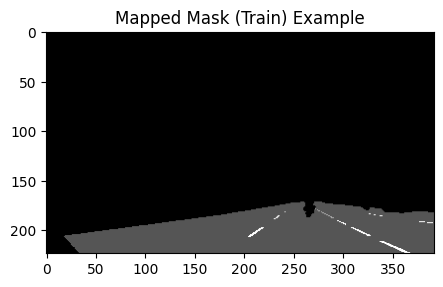

In [15]:
import matplotlib.pyplot as plt

# Unpack all THREE items returned by the dataset
image_original_sample, mask_sample = train_dataset[0]

# The rest of the code works as intended to display the mask
plt.figure(figsize=(5, 5))
plt.imshow(mask_sample, cmap='gray')
plt.title("Mapped Mask (Train) Example")
plt.axis('on')
plt.show()

# Logging Images Shape

In [16]:
print('Total of Train Images:', len(train_dataset))
print('Total of Validation Images:', len(VAL_MASK_PATH))

Total of Train Images: 206
Total of Validation Images: 68


# Dataset Preparation Class

# Performance Metrics

## Loss Functions

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = ((1 - pt) ** self.gamma) * CE_loss
        if self.alpha is not None:
            F_loss *= self.alpha[targets]
        return torch.mean(F_loss) if self.reduce else F_loss

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        targets = F.one_hot(targets, num_classes=inputs.size(1)).permute(0, 3, 1, 2).float()
        inputs = inputs.contiguous().view(-1)
        targets = targets.contiguous().view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class CombinedSegmentationLoss(nn.Module):
    def __init__(self, weights=None):
        super(CombinedSegmentationLoss, self).__init__()
        self.focal_loss = FocalLoss(alpha=weights, gamma=2.0, reduce=True)
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        return self.focal_loss(inputs, targets) + self.dice_loss(inputs, targets) + self.ce_loss(inputs, targets)

# Main Training Process

## Define Models Used

In [18]:
backbone_model = ResNet18Backbone(pretrained=True)
model = FLLENet_EndToEnd(num_classes=NUM_CLASSES)
model.to(device)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

FLLENet_EndToEnd(
  (llem): EnhanceNet(
    (relu): ReLU(inplace=True)
    (e_conv1): CSDN_Tem(
      (depth_conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
      (point_conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (e_conv2): CSDN_Tem(
      (depth_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (point_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (e_conv3): CSDN_Tem(
      (depth_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (point_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (e_conv4): CSDN_Tem(
      (depth_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (point_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (e_conv5): CSDN_Tem(
      (depth_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
      (point_conv):

## Define Optimizers and Scheduler

In [19]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
optimizer = optim.AdamW([
    {'params': model.llem.parameters(), 'lr': LEARNING_RATE / 10},  # Use a smaller LR for the pre-trained part
    {'params': model.segmentation_network.parameters(), 'lr': LEARNING_RATE},
    {'params': model.afm.parameters(), 'lr': LEARNING_RATE}
], lr=LEARNING_RATE, weight_decay=1e-4)

jaccard = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES, average='macro', ignore_index=0).to(device)
accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES, average='macro', ignore_index=0).to(device)

## Preparing Datasets and Loaders

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, jaccard_metric, accuracy_metric, num_epochs, device, patience):
    history = {'train_loss': [], 'train_iou': [], 'train_acc': [], 'val_loss': [], 'val_iou': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_weights = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        jaccard_metric.reset()
        accuracy_metric.reset() # Reset accuracy metric

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [T]")
        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            output_mask, _ = model(images)
            loss = criterion(output_mask, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            jaccard_metric.update(output_mask, masks)
            accuracy_metric.update(output_mask, masks) # Update accuracy
            progress_bar.set_postfix({'Loss': f"{loss.item():.4f}"})

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_iou = jaccard_metric.compute().item()
        epoch_acc = accuracy_metric.compute().item() # Compute accuracy
        
        history['train_loss'].append(epoch_loss)
        history['train_iou'].append(epoch_iou)
        history['train_acc'].append(epoch_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {epoch_loss:.4f}, Train IoU: {epoch_iou:.4f}, Train Acc: {epoch_acc:.4f}")
        
        val_loss, val_iou, val_acc = validate_model(model, val_loader, criterion, jaccard_metric, accuracy_metric, device)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(best_model_weights, 'best_model.pth')
            print(f"✨ New best model saved with validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("🛑 Early stopping triggered!")
            break
            
    if best_model_weights:
        model.load_state_dict(best_model_weights)
    return model, history

def validate_model(model, val_loader, criterion, jaccard_metric, accuracy_metric, device):
    model.eval()
    val_loss = 0.0
    jaccard_metric.reset()
    accuracy_metric.reset() # Reset accuracy metric
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validation [V]")
        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)
            output_mask, _ = model(images)
            loss = criterion(output_mask, masks)
            val_loss += loss.item() * images.size(0)
            jaccard_metric.update(output_mask, masks)
            accuracy_metric.update(output_mask, masks) # Update accuracy
            progress_bar.set_postfix({'Val Loss': loss.item()})

    avg_loss = val_loss / len(val_loader.dataset)
    avg_iou = jaccard_metric.compute().item()
    avg_acc = accuracy_metric.compute().item() # Compute accuracy
    
    print(f"Validation -> Avg Val Loss: {avg_loss:.4f}, Avg Val IoU: {avg_iou:.4f}, Avg Val Acc: {avg_acc:.4f}")
    return avg_loss, avg_iou, avg_acc

In [21]:
def visualize_results(model, dataset, history, device, num_samples=4):
    # ... (Plotting code for metrics remains the same) ...

    # UPDATE: Define a colormap to match your example image
    # Black, Red, Green, Yellow
    custom_cmap = ListedColormap([
        [0, 0, 0],       # Background
        [1, 0, 0],       # Road
        [0, 1, 0],       # lm_solid
        [1, 1, 0],       # lm_dashed
    ])

    # Visualize image results
    model.eval()
    fig, axes = plt.subplots(num_samples, 4, figsize=(24, 6 * num_samples)) # Increased figure size
    fig.suptitle("Original vs. Enhanced vs. Ground Truth vs. Predicted", fontsize=16)
    
    # Take random samples for better variety
    indices = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(indices):
        # The dataset now correctly returns images in the [0, 1] range
        original_img, gt_mask = dataset[idx] 
        input_tensor = original_img.unsqueeze(0).to(device)

        with torch.no_grad():
            # The model handles enhancement first, then normalization internally
            pred_mask_logits, enhanced_img_tensor = model(input_tensor)
        
        pred_mask = torch.argmax(pred_mask_logits.squeeze(0), dim=0).cpu().numpy()
        enhanced_img = enhanced_img_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
        
        # --- Display Panel 1: Original Image ---
        axes[i, 0].imshow(np.clip(original_img.permute(1, 2, 0).numpy(), 0, 1))
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')
        
        # --- Display Panel 2: Enhanced Image ---
        axes[i, 1].imshow(np.clip(enhanced_img, 0, 1))
        axes[i, 1].set_title("Enhanced")
        axes[i, 1].axis('off')
        
        # --- Display Panel 3: Ground Truth Mask ---
        axes[i, 2].imshow(gt_mask.numpy(), cmap=custom_cmap, vmin=0, vmax=NUM_CLASSES-1)
        axes[i, 2].set_title("Ground Truth Mask")
        axes[i, 2].axis('off')
        
        # --- Display Panel 4: Predicted Mask ---
        axes[i, 3].imshow(pred_mask, cmap=custom_cmap, vmin=0, vmax=NUM_CLASSES-1)
        axes[i, 3].set_title("Predicted Mask")
        axes[i, 3].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Found 206 training images and 68 validation images.
✅ Successfully loaded pre-trained weights into model.llem from /kaggle/input/zerodce_pp/pytorch/default/1/final.pth


Epoch 1/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1/1000 -> Train Loss: 1.8510, Train IoU: 0.2966, Train Acc: 0.2499


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 2.7836, Avg Val IoU: 0.3200, Avg Val Acc: 0.2438
✨ New best model saved with validation loss: 2.7836


Epoch 2/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2/1000 -> Train Loss: 0.7571, Train IoU: 0.3092, Train Acc: 0.2362


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 1.7906, Avg Val IoU: 0.3032, Avg Val Acc: 0.2306
✨ New best model saved with validation loss: 1.7906


Epoch 3/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3/1000 -> Train Loss: 0.4121, Train IoU: 0.3077, Train Acc: 0.2349


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.5549, Avg Val IoU: 0.3028, Avg Val Acc: 0.2304
✨ New best model saved with validation loss: 0.5549


Epoch 4/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4/1000 -> Train Loss: 0.2768, Train IoU: 0.3103, Train Acc: 0.2369


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.3148, Avg Val IoU: 0.2993, Avg Val Acc: 0.2277
✨ New best model saved with validation loss: 0.3148


Epoch 5/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5/1000 -> Train Loss: 0.2108, Train IoU: 0.3103, Train Acc: 0.2370


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.2465, Avg Val IoU: 0.2952, Avg Val Acc: 0.2246
✨ New best model saved with validation loss: 0.2465


Epoch 6/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6/1000 -> Train Loss: 0.1690, Train IoU: 0.3224, Train Acc: 0.2461


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.2028, Avg Val IoU: 0.3123, Avg Val Acc: 0.2376
✨ New best model saved with validation loss: 0.2028


Epoch 7/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7/1000 -> Train Loss: 0.1446, Train IoU: 0.3306, Train Acc: 0.2523


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1871, Avg Val IoU: 0.3163, Avg Val Acc: 0.2406
✨ New best model saved with validation loss: 0.1871


Epoch 8/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8/1000 -> Train Loss: 0.1284, Train IoU: 0.3424, Train Acc: 0.2615


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1743, Avg Val IoU: 0.3167, Avg Val Acc: 0.2410
✨ New best model saved with validation loss: 0.1743


Epoch 9/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9/1000 -> Train Loss: 0.1202, Train IoU: 0.3726, Train Acc: 0.2855


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1819, Avg Val IoU: 0.3290, Avg Val Acc: 0.2503
Patience: 1/100


Epoch 10/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10/1000 -> Train Loss: 0.1112, Train IoU: 0.3996, Train Acc: 0.3066


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1668, Avg Val IoU: 0.3376, Avg Val Acc: 0.2568
✨ New best model saved with validation loss: 0.1668


Epoch 11/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11/1000 -> Train Loss: 0.1030, Train IoU: 0.4232, Train Acc: 0.3255


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1467, Avg Val IoU: 0.3811, Avg Val Acc: 0.2912
✨ New best model saved with validation loss: 0.1467


Epoch 12/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12/1000 -> Train Loss: 0.0978, Train IoU: 0.4377, Train Acc: 0.3386


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1441, Avg Val IoU: 0.3994, Avg Val Acc: 0.3052
✨ New best model saved with validation loss: 0.1441


Epoch 13/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13/1000 -> Train Loss: 0.0911, Train IoU: 0.4707, Train Acc: 0.3678


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1418, Avg Val IoU: 0.4432, Avg Val Acc: 0.3435
✨ New best model saved with validation loss: 0.1418


Epoch 14/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14/1000 -> Train Loss: 0.0891, Train IoU: 0.4844, Train Acc: 0.3778


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1335, Avg Val IoU: 0.4935, Avg Val Acc: 0.3894
✨ New best model saved with validation loss: 0.1335


Epoch 15/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15/1000 -> Train Loss: 0.0879, Train IoU: 0.5060, Train Acc: 0.3978


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1297, Avg Val IoU: 0.4584, Avg Val Acc: 0.3527
✨ New best model saved with validation loss: 0.1297


Epoch 16/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16/1000 -> Train Loss: 0.0817, Train IoU: 0.5198, Train Acc: 0.4105


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1268, Avg Val IoU: 0.5083, Avg Val Acc: 0.4000
✨ New best model saved with validation loss: 0.1268


Epoch 17/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17/1000 -> Train Loss: 0.0791, Train IoU: 0.5412, Train Acc: 0.4288


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1243, Avg Val IoU: 0.4911, Avg Val Acc: 0.3814
✨ New best model saved with validation loss: 0.1243


Epoch 18/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18/1000 -> Train Loss: 0.0761, Train IoU: 0.5524, Train Acc: 0.4389


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1232, Avg Val IoU: 0.4819, Avg Val Acc: 0.3705
✨ New best model saved with validation loss: 0.1232


Epoch 19/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19/1000 -> Train Loss: 0.0746, Train IoU: 0.5602, Train Acc: 0.4477


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1211, Avg Val IoU: 0.5173, Avg Val Acc: 0.4015
✨ New best model saved with validation loss: 0.1211


Epoch 20/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 20/1000 -> Train Loss: 0.0737, Train IoU: 0.5787, Train Acc: 0.4650


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1294, Avg Val IoU: 0.5166, Avg Val Acc: 0.4013
Patience: 1/100


Epoch 21/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 21/1000 -> Train Loss: 0.0721, Train IoU: 0.5855, Train Acc: 0.4709


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1237, Avg Val IoU: 0.5282, Avg Val Acc: 0.4126
Patience: 2/100


Epoch 22/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 22/1000 -> Train Loss: 0.0660, Train IoU: 0.5892, Train Acc: 0.4728


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1184, Avg Val IoU: 0.5362, Avg Val Acc: 0.4174
✨ New best model saved with validation loss: 0.1184


Epoch 23/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 23/1000 -> Train Loss: 0.0665, Train IoU: 0.5941, Train Acc: 0.4783


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1137, Avg Val IoU: 0.5780, Avg Val Acc: 0.4591
✨ New best model saved with validation loss: 0.1137


Epoch 24/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 24/1000 -> Train Loss: 0.0660, Train IoU: 0.6003, Train Acc: 0.4838


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1155, Avg Val IoU: 0.5001, Avg Val Acc: 0.3838
Patience: 1/100


Epoch 25/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 25/1000 -> Train Loss: 0.0645, Train IoU: 0.6090, Train Acc: 0.4922


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1140, Avg Val IoU: 0.5987, Avg Val Acc: 0.4827
Patience: 2/100


Epoch 26/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 26/1000 -> Train Loss: 0.0618, Train IoU: 0.6105, Train Acc: 0.4920


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1149, Avg Val IoU: 0.5771, Avg Val Acc: 0.4531
Patience: 3/100


Epoch 27/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 27/1000 -> Train Loss: 0.0608, Train IoU: 0.6198, Train Acc: 0.5027


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1112, Avg Val IoU: 0.6109, Avg Val Acc: 0.4906
✨ New best model saved with validation loss: 0.1112


Epoch 28/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 28/1000 -> Train Loss: 0.0603, Train IoU: 0.6202, Train Acc: 0.5009


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1090, Avg Val IoU: 0.6154, Avg Val Acc: 0.4964
✨ New best model saved with validation loss: 0.1090


Epoch 29/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 29/1000 -> Train Loss: 0.0592, Train IoU: 0.6243, Train Acc: 0.5065


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1065, Avg Val IoU: 0.6252, Avg Val Acc: 0.5091
✨ New best model saved with validation loss: 0.1065


Epoch 30/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 30/1000 -> Train Loss: 0.0581, Train IoU: 0.6342, Train Acc: 0.5135


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1073, Avg Val IoU: 0.6338, Avg Val Acc: 0.5193
Patience: 1/100


Epoch 31/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 31/1000 -> Train Loss: 0.0578, Train IoU: 0.6303, Train Acc: 0.5129


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1074, Avg Val IoU: 0.6638, Avg Val Acc: 0.5618
Patience: 2/100


Epoch 32/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 32/1000 -> Train Loss: 0.0578, Train IoU: 0.6347, Train Acc: 0.5146


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1141, Avg Val IoU: 0.6414, Avg Val Acc: 0.5295
Patience: 3/100


Epoch 33/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 33/1000 -> Train Loss: 0.0550, Train IoU: 0.6402, Train Acc: 0.5200


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1051, Avg Val IoU: 0.6657, Avg Val Acc: 0.5592
✨ New best model saved with validation loss: 0.1051


Epoch 34/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 34/1000 -> Train Loss: 0.0548, Train IoU: 0.6456, Train Acc: 0.5222


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1056, Avg Val IoU: 0.6399, Avg Val Acc: 0.5114
Patience: 1/100


Epoch 35/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 35/1000 -> Train Loss: 0.0546, Train IoU: 0.6436, Train Acc: 0.5183


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1056, Avg Val IoU: 0.6439, Avg Val Acc: 0.5165
Patience: 2/100


Epoch 36/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 36/1000 -> Train Loss: 0.0543, Train IoU: 0.6512, Train Acc: 0.5325


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1017, Avg Val IoU: 0.6777, Avg Val Acc: 0.5770
✨ New best model saved with validation loss: 0.1017


Epoch 37/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 37/1000 -> Train Loss: 0.0546, Train IoU: 0.6554, Train Acc: 0.5330


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1038, Avg Val IoU: 0.6625, Avg Val Acc: 0.5472
Patience: 1/100


Epoch 38/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 38/1000 -> Train Loss: 0.0521, Train IoU: 0.6621, Train Acc: 0.5380


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1003, Avg Val IoU: 0.6467, Avg Val Acc: 0.5182
✨ New best model saved with validation loss: 0.1003


Epoch 39/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 39/1000 -> Train Loss: 0.0501, Train IoU: 0.6616, Train Acc: 0.5387


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1029, Avg Val IoU: 0.6696, Avg Val Acc: 0.5545
Patience: 1/100


Epoch 40/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 40/1000 -> Train Loss: 0.0513, Train IoU: 0.6637, Train Acc: 0.5411


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1021, Avg Val IoU: 0.6774, Avg Val Acc: 0.5668
Patience: 2/100


Epoch 41/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 41/1000 -> Train Loss: 0.0501, Train IoU: 0.6681, Train Acc: 0.5428


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1006, Avg Val IoU: 0.6798, Avg Val Acc: 0.5635
Patience: 3/100


Epoch 42/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 42/1000 -> Train Loss: 0.0498, Train IoU: 0.6696, Train Acc: 0.5459


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0962, Avg Val IoU: 0.6308, Avg Val Acc: 0.4980
✨ New best model saved with validation loss: 0.0962


Epoch 43/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 43/1000 -> Train Loss: 0.0495, Train IoU: 0.6724, Train Acc: 0.5450


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1051, Avg Val IoU: 0.6788, Avg Val Acc: 0.5619
Patience: 1/100


Epoch 44/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 44/1000 -> Train Loss: 0.0486, Train IoU: 0.6781, Train Acc: 0.5543


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0979, Avg Val IoU: 0.6762, Avg Val Acc: 0.5503
Patience: 2/100


Epoch 45/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 45/1000 -> Train Loss: 0.0477, Train IoU: 0.6730, Train Acc: 0.5465


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1028, Avg Val IoU: 0.6837, Avg Val Acc: 0.5587
Patience: 3/100


Epoch 46/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 46/1000 -> Train Loss: 0.0473, Train IoU: 0.6750, Train Acc: 0.5508


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1044, Avg Val IoU: 0.6842, Avg Val Acc: 0.5632
Patience: 4/100


Epoch 47/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 47/1000 -> Train Loss: 0.0472, Train IoU: 0.6789, Train Acc: 0.5531


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0984, Avg Val IoU: 0.6820, Avg Val Acc: 0.5543
Patience: 5/100


Epoch 48/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 48/1000 -> Train Loss: 0.0458, Train IoU: 0.6795, Train Acc: 0.5530


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0985, Avg Val IoU: 0.6739, Avg Val Acc: 0.5450
Patience: 6/100


Epoch 49/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 49/1000 -> Train Loss: 0.0441, Train IoU: 0.6813, Train Acc: 0.5539


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0993, Avg Val IoU: 0.6938, Avg Val Acc: 0.5765
Patience: 7/100


Epoch 50/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 50/1000 -> Train Loss: 0.0459, Train IoU: 0.6787, Train Acc: 0.5519


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1016, Avg Val IoU: 0.6994, Avg Val Acc: 0.5847
Patience: 8/100


Epoch 51/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 51/1000 -> Train Loss: 0.0455, Train IoU: 0.6879, Train Acc: 0.5612


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1094, Avg Val IoU: 0.6791, Avg Val Acc: 0.5464
Patience: 9/100


Epoch 52/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 52/1000 -> Train Loss: 0.0445, Train IoU: 0.6884, Train Acc: 0.5595


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0975, Avg Val IoU: 0.6967, Avg Val Acc: 0.5843
Patience: 10/100


Epoch 53/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 53/1000 -> Train Loss: 0.0435, Train IoU: 0.6888, Train Acc: 0.5636


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0973, Avg Val IoU: 0.6981, Avg Val Acc: 0.5789
Patience: 11/100


Epoch 54/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 54/1000 -> Train Loss: 0.0436, Train IoU: 0.6949, Train Acc: 0.5650


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0959, Avg Val IoU: 0.6884, Avg Val Acc: 0.5589
✨ New best model saved with validation loss: 0.0959


Epoch 55/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 55/1000 -> Train Loss: 0.0427, Train IoU: 0.6883, Train Acc: 0.5597


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1022, Avg Val IoU: 0.7022, Avg Val Acc: 0.5806
Patience: 1/100


Epoch 56/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 56/1000 -> Train Loss: 0.0424, Train IoU: 0.6961, Train Acc: 0.5700


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1002, Avg Val IoU: 0.6943, Avg Val Acc: 0.5638
Patience: 2/100


Epoch 57/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 57/1000 -> Train Loss: 0.0430, Train IoU: 0.6888, Train Acc: 0.5605


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0995, Avg Val IoU: 0.7035, Avg Val Acc: 0.5826
Patience: 3/100


Epoch 58/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 58/1000 -> Train Loss: 0.0435, Train IoU: 0.6955, Train Acc: 0.5687


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0978, Avg Val IoU: 0.7073, Avg Val Acc: 0.5898
Patience: 4/100


Epoch 59/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 59/1000 -> Train Loss: 0.0415, Train IoU: 0.6955, Train Acc: 0.5650


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0987, Avg Val IoU: 0.6839, Avg Val Acc: 0.5469
Patience: 5/100


Epoch 60/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 60/1000 -> Train Loss: 0.0417, Train IoU: 0.7025, Train Acc: 0.5729


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0961, Avg Val IoU: 0.7114, Avg Val Acc: 0.6069
Patience: 6/100


Epoch 61/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 61/1000 -> Train Loss: 0.0410, Train IoU: 0.7037, Train Acc: 0.5752


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1005, Avg Val IoU: 0.6782, Avg Val Acc: 0.5445
Patience: 7/100


Epoch 62/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 62/1000 -> Train Loss: 0.0422, Train IoU: 0.7023, Train Acc: 0.5731


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0972, Avg Val IoU: 0.6935, Avg Val Acc: 0.5580
Patience: 8/100


Epoch 63/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 63/1000 -> Train Loss: 0.0391, Train IoU: 0.6986, Train Acc: 0.5665


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0957, Avg Val IoU: 0.7121, Avg Val Acc: 0.6124
✨ New best model saved with validation loss: 0.0957


Epoch 64/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 64/1000 -> Train Loss: 0.0404, Train IoU: 0.7101, Train Acc: 0.5788


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0999, Avg Val IoU: 0.6929, Avg Val Acc: 0.5642
Patience: 1/100


Epoch 65/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 65/1000 -> Train Loss: 0.0415, Train IoU: 0.7035, Train Acc: 0.5729


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1000, Avg Val IoU: 0.7139, Avg Val Acc: 0.6004
Patience: 2/100


Epoch 66/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 66/1000 -> Train Loss: 0.0394, Train IoU: 0.7109, Train Acc: 0.5822


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0938, Avg Val IoU: 0.7128, Avg Val Acc: 0.5885
✨ New best model saved with validation loss: 0.0938


Epoch 67/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 67/1000 -> Train Loss: 0.0392, Train IoU: 0.7132, Train Acc: 0.5807


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0957, Avg Val IoU: 0.7084, Avg Val Acc: 0.5795
Patience: 1/100


Epoch 68/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 68/1000 -> Train Loss: 0.0374, Train IoU: 0.7130, Train Acc: 0.5797


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0976, Avg Val IoU: 0.7019, Avg Val Acc: 0.5753
Patience: 2/100


Epoch 69/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 69/1000 -> Train Loss: 0.0380, Train IoU: 0.7142, Train Acc: 0.5836


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0947, Avg Val IoU: 0.7122, Avg Val Acc: 0.5835
Patience: 3/100


Epoch 70/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 70/1000 -> Train Loss: 0.0389, Train IoU: 0.7122, Train Acc: 0.5787


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0945, Avg Val IoU: 0.7157, Avg Val Acc: 0.5922
Patience: 4/100


Epoch 71/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 71/1000 -> Train Loss: 0.0405, Train IoU: 0.7134, Train Acc: 0.5814


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0938, Avg Val IoU: 0.6935, Avg Val Acc: 0.5563
Patience: 5/100


Epoch 72/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 72/1000 -> Train Loss: 0.0386, Train IoU: 0.7129, Train Acc: 0.5817


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0972, Avg Val IoU: 0.7196, Avg Val Acc: 0.6184
Patience: 6/100


Epoch 73/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 73/1000 -> Train Loss: 0.0381, Train IoU: 0.7098, Train Acc: 0.5775


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0929, Avg Val IoU: 0.7188, Avg Val Acc: 0.5905
✨ New best model saved with validation loss: 0.0929


Epoch 74/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 74/1000 -> Train Loss: 0.0378, Train IoU: 0.7181, Train Acc: 0.5855


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0929, Avg Val IoU: 0.7113, Avg Val Acc: 0.5764
Patience: 1/100


Epoch 75/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 75/1000 -> Train Loss: 0.0364, Train IoU: 0.7160, Train Acc: 0.5838


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0958, Avg Val IoU: 0.7071, Avg Val Acc: 0.5732
Patience: 2/100


Epoch 76/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 76/1000 -> Train Loss: 0.0364, Train IoU: 0.7229, Train Acc: 0.5894


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0956, Avg Val IoU: 0.6927, Avg Val Acc: 0.5513
Patience: 3/100


Epoch 77/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 77/1000 -> Train Loss: 0.0366, Train IoU: 0.7178, Train Acc: 0.5845


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0973, Avg Val IoU: 0.7222, Avg Val Acc: 0.6026
Patience: 4/100


Epoch 78/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 78/1000 -> Train Loss: 0.0369, Train IoU: 0.7166, Train Acc: 0.5855


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0926, Avg Val IoU: 0.7144, Avg Val Acc: 0.5823
✨ New best model saved with validation loss: 0.0926


Epoch 79/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 79/1000 -> Train Loss: 0.0371, Train IoU: 0.7223, Train Acc: 0.5877


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0917, Avg Val IoU: 0.7209, Avg Val Acc: 0.5888
✨ New best model saved with validation loss: 0.0917


Epoch 80/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 80/1000 -> Train Loss: 0.0365, Train IoU: 0.7204, Train Acc: 0.5870


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0930, Avg Val IoU: 0.7080, Avg Val Acc: 0.5688
Patience: 1/100


Epoch 81/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 81/1000 -> Train Loss: 0.0360, Train IoU: 0.7226, Train Acc: 0.5888


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0938, Avg Val IoU: 0.7108, Avg Val Acc: 0.5724
Patience: 2/100


Epoch 82/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 82/1000 -> Train Loss: 0.0349, Train IoU: 0.7216, Train Acc: 0.5892


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0955, Avg Val IoU: 0.7232, Avg Val Acc: 0.5893
Patience: 3/100


Epoch 83/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 83/1000 -> Train Loss: 0.0349, Train IoU: 0.7191, Train Acc: 0.5851


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0973, Avg Val IoU: 0.7236, Avg Val Acc: 0.5923
Patience: 4/100


Epoch 84/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 84/1000 -> Train Loss: 0.0345, Train IoU: 0.7260, Train Acc: 0.5913


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0954, Avg Val IoU: 0.7238, Avg Val Acc: 0.5967
Patience: 5/100


Epoch 85/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 85/1000 -> Train Loss: 0.0336, Train IoU: 0.7223, Train Acc: 0.5882


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0957, Avg Val IoU: 0.7252, Avg Val Acc: 0.6059
Patience: 6/100


Epoch 86/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 86/1000 -> Train Loss: 0.0337, Train IoU: 0.7268, Train Acc: 0.5950


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0935, Avg Val IoU: 0.7295, Avg Val Acc: 0.6155
Patience: 7/100


Epoch 87/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 87/1000 -> Train Loss: 0.0348, Train IoU: 0.7267, Train Acc: 0.5908


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0954, Avg Val IoU: 0.7269, Avg Val Acc: 0.5918
Patience: 8/100


Epoch 88/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 88/1000 -> Train Loss: 0.0339, Train IoU: 0.7308, Train Acc: 0.5959


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0957, Avg Val IoU: 0.7169, Avg Val Acc: 0.5780
Patience: 9/100


Epoch 89/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 89/1000 -> Train Loss: 0.0331, Train IoU: 0.7302, Train Acc: 0.5931


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0923, Avg Val IoU: 0.7254, Avg Val Acc: 0.5924
Patience: 10/100


Epoch 90/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 90/1000 -> Train Loss: 0.0336, Train IoU: 0.7320, Train Acc: 0.5975


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0942, Avg Val IoU: 0.7254, Avg Val Acc: 0.6140
Patience: 11/100


Epoch 91/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 91/1000 -> Train Loss: 0.0335, Train IoU: 0.7257, Train Acc: 0.5919


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0969, Avg Val IoU: 0.7299, Avg Val Acc: 0.6034
Patience: 12/100


Epoch 92/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 92/1000 -> Train Loss: 0.0339, Train IoU: 0.7344, Train Acc: 0.5982


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0918, Avg Val IoU: 0.7287, Avg Val Acc: 0.5880
Patience: 13/100


Epoch 93/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 93/1000 -> Train Loss: 0.0341, Train IoU: 0.7367, Train Acc: 0.5978


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0987, Avg Val IoU: 0.7305, Avg Val Acc: 0.5918
Patience: 14/100


Epoch 94/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 94/1000 -> Train Loss: 0.0333, Train IoU: 0.7352, Train Acc: 0.5997


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0952, Avg Val IoU: 0.7291, Avg Val Acc: 0.6127
Patience: 15/100


Epoch 95/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 95/1000 -> Train Loss: 0.0327, Train IoU: 0.7399, Train Acc: 0.6006


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0945, Avg Val IoU: 0.7281, Avg Val Acc: 0.5878
Patience: 16/100


Epoch 96/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 96/1000 -> Train Loss: 0.0329, Train IoU: 0.7309, Train Acc: 0.5965


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0959, Avg Val IoU: 0.7303, Avg Val Acc: 0.5985
Patience: 17/100


Epoch 97/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 97/1000 -> Train Loss: 0.0326, Train IoU: 0.7389, Train Acc: 0.6023


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0941, Avg Val IoU: 0.7339, Avg Val Acc: 0.6063
Patience: 18/100


Epoch 98/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 98/1000 -> Train Loss: 0.0338, Train IoU: 0.7359, Train Acc: 0.5983


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0949, Avg Val IoU: 0.7373, Avg Val Acc: 0.6084
Patience: 19/100


Epoch 99/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 99/1000 -> Train Loss: 0.0330, Train IoU: 0.7386, Train Acc: 0.6012


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0965, Avg Val IoU: 0.7328, Avg Val Acc: 0.6125
Patience: 20/100


Epoch 100/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 100/1000 -> Train Loss: 0.0318, Train IoU: 0.7413, Train Acc: 0.6027


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0953, Avg Val IoU: 0.7307, Avg Val Acc: 0.5967
Patience: 21/100


Epoch 101/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 101/1000 -> Train Loss: 0.0320, Train IoU: 0.7439, Train Acc: 0.6070


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0935, Avg Val IoU: 0.7386, Avg Val Acc: 0.6113
Patience: 22/100


Epoch 102/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 102/1000 -> Train Loss: 0.0322, Train IoU: 0.7335, Train Acc: 0.5957


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0928, Avg Val IoU: 0.7349, Avg Val Acc: 0.6129
Patience: 23/100


Epoch 103/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 103/1000 -> Train Loss: 0.0322, Train IoU: 0.7438, Train Acc: 0.6055


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0948, Avg Val IoU: 0.7374, Avg Val Acc: 0.5978
Patience: 24/100


Epoch 104/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 104/1000 -> Train Loss: 0.0322, Train IoU: 0.7410, Train Acc: 0.6021


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0993, Avg Val IoU: 0.7427, Avg Val Acc: 0.6098
Patience: 25/100


Epoch 105/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 105/1000 -> Train Loss: 0.0306, Train IoU: 0.7471, Train Acc: 0.6079


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0965, Avg Val IoU: 0.7424, Avg Val Acc: 0.6139
Patience: 26/100


Epoch 106/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 106/1000 -> Train Loss: 0.0319, Train IoU: 0.7448, Train Acc: 0.6060


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0945, Avg Val IoU: 0.7409, Avg Val Acc: 0.6159
Patience: 27/100


Epoch 107/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 107/1000 -> Train Loss: 0.0321, Train IoU: 0.7427, Train Acc: 0.6021


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0961, Avg Val IoU: 0.7374, Avg Val Acc: 0.6021
Patience: 28/100


Epoch 108/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 108/1000 -> Train Loss: 0.0312, Train IoU: 0.7435, Train Acc: 0.6059


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0939, Avg Val IoU: 0.7357, Avg Val Acc: 0.6040
Patience: 29/100


Epoch 109/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 109/1000 -> Train Loss: 0.0315, Train IoU: 0.7458, Train Acc: 0.6064


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0998, Avg Val IoU: 0.7343, Avg Val Acc: 0.6092
Patience: 30/100


Epoch 110/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 110/1000 -> Train Loss: 0.0308, Train IoU: 0.7441, Train Acc: 0.6049


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0954, Avg Val IoU: 0.7451, Avg Val Acc: 0.6242
Patience: 31/100


Epoch 111/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 111/1000 -> Train Loss: 0.0309, Train IoU: 0.7516, Train Acc: 0.6105


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0968, Avg Val IoU: 0.7356, Avg Val Acc: 0.5966
Patience: 32/100


Epoch 112/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 112/1000 -> Train Loss: 0.0298, Train IoU: 0.7521, Train Acc: 0.6105


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0935, Avg Val IoU: 0.7392, Avg Val Acc: 0.6133
Patience: 33/100


Epoch 113/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 113/1000 -> Train Loss: 0.0305, Train IoU: 0.7478, Train Acc: 0.6066


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0944, Avg Val IoU: 0.7403, Avg Val Acc: 0.6006
Patience: 34/100


Epoch 114/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 114/1000 -> Train Loss: 0.0299, Train IoU: 0.7501, Train Acc: 0.6126


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0972, Avg Val IoU: 0.7369, Avg Val Acc: 0.5959
Patience: 35/100


Epoch 115/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 115/1000 -> Train Loss: 0.0308, Train IoU: 0.7512, Train Acc: 0.6093


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1020, Avg Val IoU: 0.7406, Avg Val Acc: 0.6076
Patience: 36/100


Epoch 116/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 116/1000 -> Train Loss: 0.0300, Train IoU: 0.7534, Train Acc: 0.6119


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0948, Avg Val IoU: 0.7416, Avg Val Acc: 0.5991
Patience: 37/100


Epoch 117/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 117/1000 -> Train Loss: 0.0301, Train IoU: 0.7535, Train Acc: 0.6123


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0954, Avg Val IoU: 0.7327, Avg Val Acc: 0.5849
Patience: 38/100


Epoch 118/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 118/1000 -> Train Loss: 0.0290, Train IoU: 0.7529, Train Acc: 0.6105


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0978, Avg Val IoU: 0.7493, Avg Val Acc: 0.6243
Patience: 39/100


Epoch 119/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 119/1000 -> Train Loss: 0.0292, Train IoU: 0.7552, Train Acc: 0.6146


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1023, Avg Val IoU: 0.7425, Avg Val Acc: 0.5990
Patience: 40/100


Epoch 120/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 120/1000 -> Train Loss: 0.0295, Train IoU: 0.7521, Train Acc: 0.6112


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0967, Avg Val IoU: 0.7501, Avg Val Acc: 0.6208
Patience: 41/100


Epoch 121/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 121/1000 -> Train Loss: 0.0296, Train IoU: 0.7534, Train Acc: 0.6122


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0991, Avg Val IoU: 0.7473, Avg Val Acc: 0.6101
Patience: 42/100


Epoch 122/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 122/1000 -> Train Loss: 0.0296, Train IoU: 0.7586, Train Acc: 0.6166


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0957, Avg Val IoU: 0.7458, Avg Val Acc: 0.6163
Patience: 43/100


Epoch 123/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 123/1000 -> Train Loss: 0.0293, Train IoU: 0.7594, Train Acc: 0.6155


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0920, Avg Val IoU: 0.7459, Avg Val Acc: 0.6007
Patience: 44/100


Epoch 124/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 124/1000 -> Train Loss: 0.0288, Train IoU: 0.7561, Train Acc: 0.6131


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1089, Avg Val IoU: 0.7529, Avg Val Acc: 0.6150
Patience: 45/100


Epoch 125/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 125/1000 -> Train Loss: 0.0292, Train IoU: 0.7594, Train Acc: 0.6163


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0952, Avg Val IoU: 0.7384, Avg Val Acc: 0.5935
Patience: 46/100


Epoch 126/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 126/1000 -> Train Loss: 0.0284, Train IoU: 0.7581, Train Acc: 0.6169


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0931, Avg Val IoU: 0.7290, Avg Val Acc: 0.5784
Patience: 47/100


Epoch 127/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 127/1000 -> Train Loss: 0.0278, Train IoU: 0.7586, Train Acc: 0.6170


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0967, Avg Val IoU: 0.7488, Avg Val Acc: 0.6103
Patience: 48/100


Epoch 128/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 128/1000 -> Train Loss: 0.0277, Train IoU: 0.7571, Train Acc: 0.6119


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0968, Avg Val IoU: 0.7476, Avg Val Acc: 0.6352
Patience: 49/100


Epoch 129/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 129/1000 -> Train Loss: 0.0284, Train IoU: 0.7603, Train Acc: 0.6176


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0982, Avg Val IoU: 0.7474, Avg Val Acc: 0.6158
Patience: 50/100


Epoch 130/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 130/1000 -> Train Loss: 0.0272, Train IoU: 0.7585, Train Acc: 0.6155


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1007, Avg Val IoU: 0.7491, Avg Val Acc: 0.6074
Patience: 51/100


Epoch 131/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 131/1000 -> Train Loss: 0.0284, Train IoU: 0.7633, Train Acc: 0.6205


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0976, Avg Val IoU: 0.7458, Avg Val Acc: 0.6064
Patience: 52/100


Epoch 132/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 132/1000 -> Train Loss: 0.0280, Train IoU: 0.7592, Train Acc: 0.6151


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0969, Avg Val IoU: 0.7499, Avg Val Acc: 0.6298
Patience: 53/100


Epoch 133/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 133/1000 -> Train Loss: 0.0276, Train IoU: 0.7648, Train Acc: 0.6212


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1036, Avg Val IoU: 0.7268, Avg Val Acc: 0.5752
Patience: 54/100


Epoch 134/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 134/1000 -> Train Loss: 0.0283, Train IoU: 0.7673, Train Acc: 0.6221


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0948, Avg Val IoU: 0.7456, Avg Val Acc: 0.6052
Patience: 55/100


Epoch 135/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 135/1000 -> Train Loss: 0.0287, Train IoU: 0.7590, Train Acc: 0.6167


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0916, Avg Val IoU: 0.7515, Avg Val Acc: 0.6118
✨ New best model saved with validation loss: 0.0916


Epoch 136/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 136/1000 -> Train Loss: 0.0289, Train IoU: 0.7636, Train Acc: 0.6196


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1007, Avg Val IoU: 0.7375, Avg Val Acc: 0.5874
Patience: 1/100


Epoch 137/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 137/1000 -> Train Loss: 0.0278, Train IoU: 0.7618, Train Acc: 0.6171


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0955, Avg Val IoU: 0.7591, Avg Val Acc: 0.6306
Patience: 2/100


Epoch 138/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 138/1000 -> Train Loss: 0.0273, Train IoU: 0.7632, Train Acc: 0.6171


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0955, Avg Val IoU: 0.7560, Avg Val Acc: 0.6202
Patience: 3/100


Epoch 139/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 139/1000 -> Train Loss: 0.0280, Train IoU: 0.7664, Train Acc: 0.6228


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0964, Avg Val IoU: 0.7533, Avg Val Acc: 0.6122
Patience: 4/100


Epoch 140/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 140/1000 -> Train Loss: 0.0279, Train IoU: 0.7676, Train Acc: 0.6232


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0992, Avg Val IoU: 0.7469, Avg Val Acc: 0.6027
Patience: 5/100


Epoch 141/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 141/1000 -> Train Loss: 0.0284, Train IoU: 0.7671, Train Acc: 0.6210


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0981, Avg Val IoU: 0.7552, Avg Val Acc: 0.6136
Patience: 6/100


Epoch 142/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 142/1000 -> Train Loss: 0.0277, Train IoU: 0.7650, Train Acc: 0.6195


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0929, Avg Val IoU: 0.7578, Avg Val Acc: 0.6239
Patience: 7/100


Epoch 143/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 143/1000 -> Train Loss: 0.0269, Train IoU: 0.7685, Train Acc: 0.6227


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0927, Avg Val IoU: 0.7437, Avg Val Acc: 0.5933
Patience: 8/100


Epoch 144/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 144/1000 -> Train Loss: 0.0273, Train IoU: 0.7710, Train Acc: 0.6228


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0951, Avg Val IoU: 0.7562, Avg Val Acc: 0.6248
Patience: 9/100


Epoch 145/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 145/1000 -> Train Loss: 0.0269, Train IoU: 0.7730, Train Acc: 0.6296


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0967, Avg Val IoU: 0.7573, Avg Val Acc: 0.6169
Patience: 10/100


Epoch 146/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 146/1000 -> Train Loss: 0.0268, Train IoU: 0.7739, Train Acc: 0.6241


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0945, Avg Val IoU: 0.7550, Avg Val Acc: 0.6121
Patience: 11/100


Epoch 147/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 147/1000 -> Train Loss: 0.0274, Train IoU: 0.7697, Train Acc: 0.6246


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0945, Avg Val IoU: 0.7528, Avg Val Acc: 0.6055
Patience: 12/100


Epoch 148/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 148/1000 -> Train Loss: 0.0264, Train IoU: 0.7739, Train Acc: 0.6272


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0994, Avg Val IoU: 0.7554, Avg Val Acc: 0.6091
Patience: 13/100


Epoch 149/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 149/1000 -> Train Loss: 0.0260, Train IoU: 0.7743, Train Acc: 0.6280


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0958, Avg Val IoU: 0.7525, Avg Val Acc: 0.6051
Patience: 14/100


Epoch 150/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 150/1000 -> Train Loss: 0.0262, Train IoU: 0.7713, Train Acc: 0.6251


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0981, Avg Val IoU: 0.7487, Avg Val Acc: 0.5993
Patience: 15/100


Epoch 151/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 151/1000 -> Train Loss: 0.0260, Train IoU: 0.7750, Train Acc: 0.6260


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0954, Avg Val IoU: 0.7632, Avg Val Acc: 0.6218
Patience: 16/100


Epoch 152/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 152/1000 -> Train Loss: 0.0249, Train IoU: 0.7741, Train Acc: 0.6282


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0973, Avg Val IoU: 0.7652, Avg Val Acc: 0.6331
Patience: 17/100


Epoch 153/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 153/1000 -> Train Loss: 0.0249, Train IoU: 0.7758, Train Acc: 0.6283


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0980, Avg Val IoU: 0.7623, Avg Val Acc: 0.6289
Patience: 18/100


Epoch 154/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 154/1000 -> Train Loss: 0.0264, Train IoU: 0.7783, Train Acc: 0.6307


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0985, Avg Val IoU: 0.7613, Avg Val Acc: 0.6176
Patience: 19/100


Epoch 155/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 155/1000 -> Train Loss: 0.0264, Train IoU: 0.7758, Train Acc: 0.6285


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0961, Avg Val IoU: 0.7609, Avg Val Acc: 0.6158
Patience: 20/100


Epoch 156/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 156/1000 -> Train Loss: 0.0260, Train IoU: 0.7744, Train Acc: 0.6255


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0971, Avg Val IoU: 0.7619, Avg Val Acc: 0.6166
Patience: 21/100


Epoch 157/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 157/1000 -> Train Loss: 0.0255, Train IoU: 0.7777, Train Acc: 0.6321


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0981, Avg Val IoU: 0.7457, Avg Val Acc: 0.5943
Patience: 22/100


Epoch 158/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 158/1000 -> Train Loss: 0.0253, Train IoU: 0.7765, Train Acc: 0.6276


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0936, Avg Val IoU: 0.7652, Avg Val Acc: 0.6343
Patience: 23/100


Epoch 159/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 159/1000 -> Train Loss: 0.0254, Train IoU: 0.7770, Train Acc: 0.6330


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0970, Avg Val IoU: 0.7381, Avg Val Acc: 0.5819
Patience: 24/100


Epoch 160/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 160/1000 -> Train Loss: 0.0251, Train IoU: 0.7776, Train Acc: 0.6272


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0998, Avg Val IoU: 0.7629, Avg Val Acc: 0.6278
Patience: 25/100


Epoch 161/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 161/1000 -> Train Loss: 0.0253, Train IoU: 0.7778, Train Acc: 0.6312


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0993, Avg Val IoU: 0.7478, Avg Val Acc: 0.5948
Patience: 26/100


Epoch 162/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 162/1000 -> Train Loss: 0.0246, Train IoU: 0.7806, Train Acc: 0.6326


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0972, Avg Val IoU: 0.7652, Avg Val Acc: 0.6273
Patience: 27/100


Epoch 163/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 163/1000 -> Train Loss: 0.0244, Train IoU: 0.7816, Train Acc: 0.6317


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0961, Avg Val IoU: 0.7526, Avg Val Acc: 0.5997
Patience: 28/100


Epoch 164/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 164/1000 -> Train Loss: 0.0248, Train IoU: 0.7809, Train Acc: 0.6321


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1007, Avg Val IoU: 0.7599, Avg Val Acc: 0.6146
Patience: 29/100


Epoch 165/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 165/1000 -> Train Loss: 0.0241, Train IoU: 0.7822, Train Acc: 0.6321


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0993, Avg Val IoU: 0.7592, Avg Val Acc: 0.6232
Patience: 30/100


Epoch 166/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 166/1000 -> Train Loss: 0.0244, Train IoU: 0.7826, Train Acc: 0.6333


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0970, Avg Val IoU: 0.7615, Avg Val Acc: 0.6233
Patience: 31/100


Epoch 167/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 167/1000 -> Train Loss: 0.0241, Train IoU: 0.7826, Train Acc: 0.6322


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0988, Avg Val IoU: 0.7618, Avg Val Acc: 0.6199
Patience: 32/100


Epoch 168/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 168/1000 -> Train Loss: 0.0246, Train IoU: 0.7797, Train Acc: 0.6354


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0978, Avg Val IoU: 0.7547, Avg Val Acc: 0.6055
Patience: 33/100


Epoch 169/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 169/1000 -> Train Loss: 0.0250, Train IoU: 0.7782, Train Acc: 0.6279


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0956, Avg Val IoU: 0.7676, Avg Val Acc: 0.6440
Patience: 34/100


Epoch 170/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 170/1000 -> Train Loss: 0.0232, Train IoU: 0.7826, Train Acc: 0.6356


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0999, Avg Val IoU: 0.7622, Avg Val Acc: 0.6179
Patience: 35/100


Epoch 171/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 171/1000 -> Train Loss: 0.0239, Train IoU: 0.7835, Train Acc: 0.6322


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0978, Avg Val IoU: 0.7644, Avg Val Acc: 0.6400
Patience: 36/100


Epoch 172/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 172/1000 -> Train Loss: 0.0247, Train IoU: 0.7827, Train Acc: 0.6377


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0986, Avg Val IoU: 0.7344, Avg Val Acc: 0.5737
Patience: 37/100


Epoch 173/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 173/1000 -> Train Loss: 0.0243, Train IoU: 0.7850, Train Acc: 0.6325


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1018, Avg Val IoU: 0.7612, Avg Val Acc: 0.6266
Patience: 38/100


Epoch 174/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 174/1000 -> Train Loss: 0.0241, Train IoU: 0.7825, Train Acc: 0.6342


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0983, Avg Val IoU: 0.7636, Avg Val Acc: 0.6224
Patience: 39/100


Epoch 175/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 175/1000 -> Train Loss: 0.0243, Train IoU: 0.7859, Train Acc: 0.6340


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0966, Avg Val IoU: 0.7691, Avg Val Acc: 0.6289
Patience: 40/100


Epoch 176/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 176/1000 -> Train Loss: 0.0237, Train IoU: 0.7891, Train Acc: 0.6389


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0996, Avg Val IoU: 0.7600, Avg Val Acc: 0.6377
Patience: 41/100


Epoch 177/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 177/1000 -> Train Loss: 0.0249, Train IoU: 0.7884, Train Acc: 0.6357


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1038, Avg Val IoU: 0.7619, Avg Val Acc: 0.6202
Patience: 42/100


Epoch 178/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 178/1000 -> Train Loss: 0.0243, Train IoU: 0.7882, Train Acc: 0.6396


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0943, Avg Val IoU: 0.7723, Avg Val Acc: 0.6338
Patience: 43/100


Epoch 179/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 179/1000 -> Train Loss: 0.0240, Train IoU: 0.7871, Train Acc: 0.6343


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0994, Avg Val IoU: 0.7648, Avg Val Acc: 0.6241
Patience: 44/100


Epoch 180/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 180/1000 -> Train Loss: 0.0245, Train IoU: 0.7901, Train Acc: 0.6394


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0984, Avg Val IoU: 0.7626, Avg Val Acc: 0.6118
Patience: 45/100


Epoch 181/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 181/1000 -> Train Loss: 0.0235, Train IoU: 0.7891, Train Acc: 0.6370


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1004, Avg Val IoU: 0.7751, Avg Val Acc: 0.6335
Patience: 46/100


Epoch 182/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 182/1000 -> Train Loss: 0.0231, Train IoU: 0.7911, Train Acc: 0.6395


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0978, Avg Val IoU: 0.7732, Avg Val Acc: 0.6457
Patience: 47/100


Epoch 183/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 183/1000 -> Train Loss: 0.0231, Train IoU: 0.7930, Train Acc: 0.6410


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0981, Avg Val IoU: 0.7588, Avg Val Acc: 0.6033
Patience: 48/100


Epoch 184/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 184/1000 -> Train Loss: 0.0230, Train IoU: 0.7911, Train Acc: 0.6394


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0993, Avg Val IoU: 0.7623, Avg Val Acc: 0.6157
Patience: 49/100


Epoch 185/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 185/1000 -> Train Loss: 0.0230, Train IoU: 0.7894, Train Acc: 0.6383


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0997, Avg Val IoU: 0.7697, Avg Val Acc: 0.6283
Patience: 50/100


Epoch 186/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 186/1000 -> Train Loss: 0.0229, Train IoU: 0.7909, Train Acc: 0.6393


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1021, Avg Val IoU: 0.7721, Avg Val Acc: 0.6335
Patience: 51/100


Epoch 187/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 187/1000 -> Train Loss: 0.0230, Train IoU: 0.7888, Train Acc: 0.6378


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1024, Avg Val IoU: 0.7666, Avg Val Acc: 0.6187
Patience: 52/100


Epoch 188/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 188/1000 -> Train Loss: 0.0226, Train IoU: 0.7906, Train Acc: 0.6394


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1017, Avg Val IoU: 0.7701, Avg Val Acc: 0.6271
Patience: 53/100


Epoch 189/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 189/1000 -> Train Loss: 0.0226, Train IoU: 0.7940, Train Acc: 0.6403


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1021, Avg Val IoU: 0.7658, Avg Val Acc: 0.6201
Patience: 54/100


Epoch 190/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 190/1000 -> Train Loss: 0.0234, Train IoU: 0.7947, Train Acc: 0.6429


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0983, Avg Val IoU: 0.7669, Avg Val Acc: 0.6214
Patience: 55/100


Epoch 191/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 191/1000 -> Train Loss: 0.0236, Train IoU: 0.7955, Train Acc: 0.6406


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1025, Avg Val IoU: 0.7741, Avg Val Acc: 0.6363
Patience: 56/100


Epoch 192/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 192/1000 -> Train Loss: 0.0231, Train IoU: 0.7934, Train Acc: 0.6420


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1035, Avg Val IoU: 0.7517, Avg Val Acc: 0.5947
Patience: 57/100


Epoch 193/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 193/1000 -> Train Loss: 0.0234, Train IoU: 0.7917, Train Acc: 0.6401


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0981, Avg Val IoU: 0.7717, Avg Val Acc: 0.6363
Patience: 58/100


Epoch 194/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 194/1000 -> Train Loss: 0.0228, Train IoU: 0.7960, Train Acc: 0.6422


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1008, Avg Val IoU: 0.7755, Avg Val Acc: 0.6397
Patience: 59/100


Epoch 195/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 195/1000 -> Train Loss: 0.0223, Train IoU: 0.7954, Train Acc: 0.6438


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1002, Avg Val IoU: 0.7708, Avg Val Acc: 0.6198
Patience: 60/100


Epoch 196/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 196/1000 -> Train Loss: 0.0225, Train IoU: 0.7989, Train Acc: 0.6438


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0991, Avg Val IoU: 0.7731, Avg Val Acc: 0.6276
Patience: 61/100


Epoch 197/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 197/1000 -> Train Loss: 0.0224, Train IoU: 0.7949, Train Acc: 0.6432


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1023, Avg Val IoU: 0.7690, Avg Val Acc: 0.6197
Patience: 62/100


Epoch 198/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 198/1000 -> Train Loss: 0.0225, Train IoU: 0.7977, Train Acc: 0.6444


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1008, Avg Val IoU: 0.7718, Avg Val Acc: 0.6228
Patience: 63/100


Epoch 199/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 199/1000 -> Train Loss: 0.0232, Train IoU: 0.7962, Train Acc: 0.6422


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0989, Avg Val IoU: 0.7704, Avg Val Acc: 0.6249
Patience: 64/100


Epoch 200/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 200/1000 -> Train Loss: 0.0229, Train IoU: 0.7944, Train Acc: 0.6406


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0992, Avg Val IoU: 0.7760, Avg Val Acc: 0.6347
Patience: 65/100


Epoch 201/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 201/1000 -> Train Loss: 0.0233, Train IoU: 0.7976, Train Acc: 0.6455


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1031, Avg Val IoU: 0.7696, Avg Val Acc: 0.6151
Patience: 66/100


Epoch 202/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 202/1000 -> Train Loss: 0.0223, Train IoU: 0.7973, Train Acc: 0.6432


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1054, Avg Val IoU: 0.7736, Avg Val Acc: 0.6329
Patience: 67/100


Epoch 203/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 203/1000 -> Train Loss: 0.0230, Train IoU: 0.7997, Train Acc: 0.6454


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1007, Avg Val IoU: 0.7686, Avg Val Acc: 0.6155
Patience: 68/100


Epoch 204/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 204/1000 -> Train Loss: 0.0223, Train IoU: 0.7996, Train Acc: 0.6445


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1023, Avg Val IoU: 0.7729, Avg Val Acc: 0.6322
Patience: 69/100


Epoch 205/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 205/1000 -> Train Loss: 0.0216, Train IoU: 0.8010, Train Acc: 0.6477


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1010, Avg Val IoU: 0.7703, Avg Val Acc: 0.6203
Patience: 70/100


Epoch 206/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 206/1000 -> Train Loss: 0.0224, Train IoU: 0.7968, Train Acc: 0.6434


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1001, Avg Val IoU: 0.7764, Avg Val Acc: 0.6272
Patience: 71/100


Epoch 207/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 207/1000 -> Train Loss: 0.0220, Train IoU: 0.7996, Train Acc: 0.6454


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1008, Avg Val IoU: 0.7734, Avg Val Acc: 0.6183
Patience: 72/100


Epoch 208/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 208/1000 -> Train Loss: 0.0221, Train IoU: 0.8026, Train Acc: 0.6484


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1060, Avg Val IoU: 0.7685, Avg Val Acc: 0.6292
Patience: 73/100


Epoch 209/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 209/1000 -> Train Loss: 0.0224, Train IoU: 0.8007, Train Acc: 0.6470


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1046, Avg Val IoU: 0.7667, Avg Val Acc: 0.6144
Patience: 74/100


Epoch 210/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 210/1000 -> Train Loss: 0.0224, Train IoU: 0.8001, Train Acc: 0.6445


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0991, Avg Val IoU: 0.7692, Avg Val Acc: 0.6090
Patience: 75/100


Epoch 211/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 211/1000 -> Train Loss: 0.0221, Train IoU: 0.7977, Train Acc: 0.6434


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1007, Avg Val IoU: 0.7793, Avg Val Acc: 0.6359
Patience: 76/100


Epoch 212/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 212/1000 -> Train Loss: 0.0222, Train IoU: 0.8011, Train Acc: 0.6456


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1009, Avg Val IoU: 0.7733, Avg Val Acc: 0.6225
Patience: 77/100


Epoch 213/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 213/1000 -> Train Loss: 0.0214, Train IoU: 0.8015, Train Acc: 0.6470


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1031, Avg Val IoU: 0.7737, Avg Val Acc: 0.6227
Patience: 78/100


Epoch 214/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 214/1000 -> Train Loss: 0.0220, Train IoU: 0.8018, Train Acc: 0.6472


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0998, Avg Val IoU: 0.7646, Avg Val Acc: 0.6044
Patience: 79/100


Epoch 215/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 215/1000 -> Train Loss: 0.0218, Train IoU: 0.8037, Train Acc: 0.6492


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1050, Avg Val IoU: 0.7738, Avg Val Acc: 0.6398
Patience: 80/100


Epoch 216/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 216/1000 -> Train Loss: 0.0221, Train IoU: 0.8049, Train Acc: 0.6481


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1005, Avg Val IoU: 0.7758, Avg Val Acc: 0.6348
Patience: 81/100


Epoch 217/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 217/1000 -> Train Loss: 0.0217, Train IoU: 0.8034, Train Acc: 0.6484


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1012, Avg Val IoU: 0.7664, Avg Val Acc: 0.6071
Patience: 82/100


Epoch 218/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 218/1000 -> Train Loss: 0.0215, Train IoU: 0.8026, Train Acc: 0.6467


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1013, Avg Val IoU: 0.7805, Avg Val Acc: 0.6360
Patience: 83/100


Epoch 219/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 219/1000 -> Train Loss: 0.0212, Train IoU: 0.8065, Train Acc: 0.6487


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0987, Avg Val IoU: 0.7825, Avg Val Acc: 0.6425
Patience: 84/100


Epoch 220/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 220/1000 -> Train Loss: 0.0213, Train IoU: 0.8079, Train Acc: 0.6528


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0990, Avg Val IoU: 0.7795, Avg Val Acc: 0.6292
Patience: 85/100


Epoch 221/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 221/1000 -> Train Loss: 0.0220, Train IoU: 0.8054, Train Acc: 0.6494


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1010, Avg Val IoU: 0.7718, Avg Val Acc: 0.6244
Patience: 86/100


Epoch 222/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 222/1000 -> Train Loss: 0.0223, Train IoU: 0.8028, Train Acc: 0.6474


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1000, Avg Val IoU: 0.7703, Avg Val Acc: 0.6126
Patience: 87/100


Epoch 223/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 223/1000 -> Train Loss: 0.0214, Train IoU: 0.8055, Train Acc: 0.6490


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1029, Avg Val IoU: 0.7733, Avg Val Acc: 0.6243
Patience: 88/100


Epoch 224/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 224/1000 -> Train Loss: 0.0214, Train IoU: 0.8060, Train Acc: 0.6501


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1029, Avg Val IoU: 0.7723, Avg Val Acc: 0.6218
Patience: 89/100


Epoch 225/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 225/1000 -> Train Loss: 0.0211, Train IoU: 0.8072, Train Acc: 0.6491


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1030, Avg Val IoU: 0.7728, Avg Val Acc: 0.6276
Patience: 90/100


Epoch 226/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 226/1000 -> Train Loss: 0.0209, Train IoU: 0.8087, Train Acc: 0.6512


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1022, Avg Val IoU: 0.7791, Avg Val Acc: 0.6318
Patience: 91/100


Epoch 227/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 227/1000 -> Train Loss: 0.0216, Train IoU: 0.8067, Train Acc: 0.6524


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1055, Avg Val IoU: 0.7713, Avg Val Acc: 0.6162
Patience: 92/100


Epoch 228/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 228/1000 -> Train Loss: 0.0213, Train IoU: 0.8058, Train Acc: 0.6470


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.0994, Avg Val IoU: 0.7798, Avg Val Acc: 0.6366
Patience: 93/100


Epoch 229/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 229/1000 -> Train Loss: 0.0205, Train IoU: 0.8068, Train Acc: 0.6512


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1076, Avg Val IoU: 0.7780, Avg Val Acc: 0.6308
Patience: 94/100


Epoch 230/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 230/1000 -> Train Loss: 0.0209, Train IoU: 0.8063, Train Acc: 0.6494


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1050, Avg Val IoU: 0.7783, Avg Val Acc: 0.6264
Patience: 95/100


Epoch 231/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 231/1000 -> Train Loss: 0.0212, Train IoU: 0.8077, Train Acc: 0.6523


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1044, Avg Val IoU: 0.7708, Avg Val Acc: 0.6193
Patience: 96/100


Epoch 232/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 232/1000 -> Train Loss: 0.0208, Train IoU: 0.8100, Train Acc: 0.6525


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1054, Avg Val IoU: 0.7808, Avg Val Acc: 0.6352
Patience: 97/100


Epoch 233/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 233/1000 -> Train Loss: 0.0213, Train IoU: 0.8116, Train Acc: 0.6537


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1017, Avg Val IoU: 0.7773, Avg Val Acc: 0.6249
Patience: 98/100


Epoch 234/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 234/1000 -> Train Loss: 0.0207, Train IoU: 0.8089, Train Acc: 0.6525


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1023, Avg Val IoU: 0.7766, Avg Val Acc: 0.6313
Patience: 99/100


Epoch 235/1000 [T]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 235/1000 -> Train Loss: 0.0206, Train IoU: 0.8111, Train Acc: 0.6524


Validation [V]:   0%|          | 0/9 [00:00<?, ?it/s]

Validation -> Avg Val Loss: 0.1017, Avg Val IoU: 0.7812, Avg Val Acc: 0.6263
Patience: 100/100
🛑 Early stopping triggered!


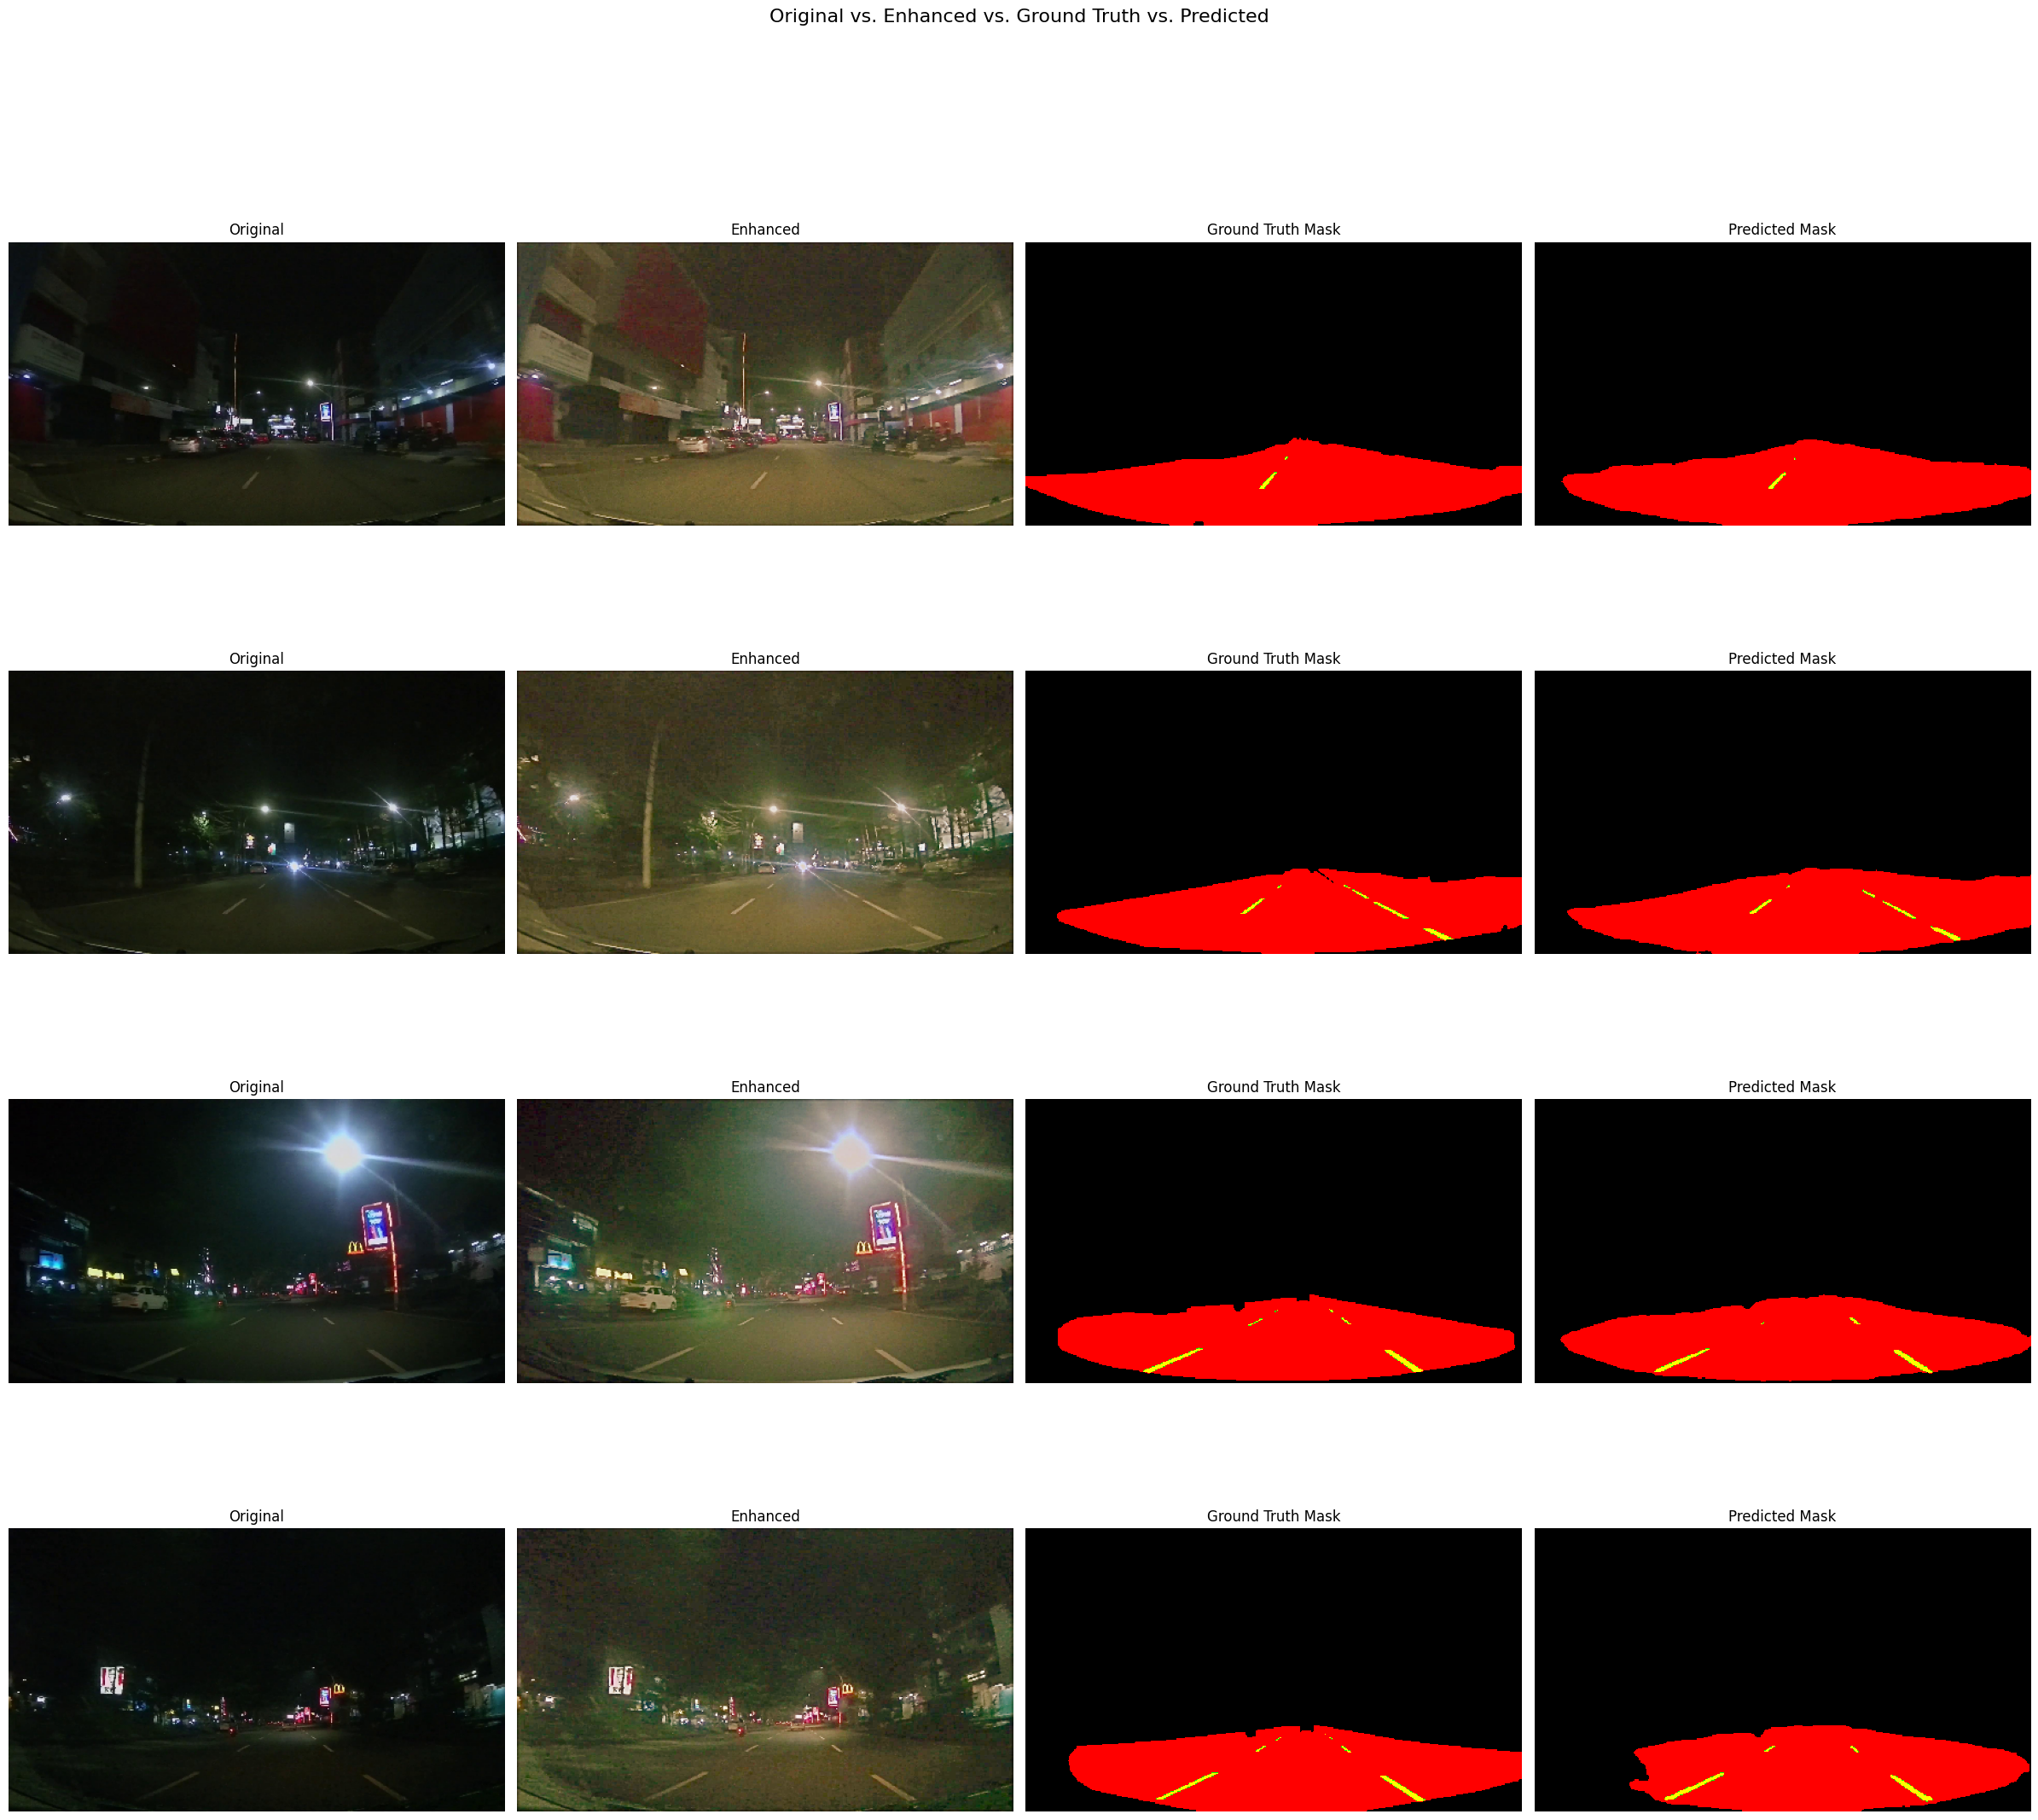

In [22]:
if not TRAIN_IMG_PATH or not VAL_IMG_PATH:
    print("!!! WARNING: No images found. Please update dataset paths.")
else:
    print(f"Found {len(train_dataset)} training images and {len(val_dataset)} validation images.")

    # --- Model, Loss, and Optimizer Setup ---
    model = FLLENet_EndToEnd(num_classes=NUM_CLASSES).to(device)
    
    # Optionally load pre-trained weights for the LLEM part
    try:
        llem_weights = torch.load(LLEM_WEIGHTS_PATH, map_location=device)
        model.llem.load_state_dict(llem_weights)
        print(f"✅ Successfully loaded pre-trained weights into model.llem from {LLEM_WEIGHTS_PATH}")
    except FileNotFoundError:
        print(f"⚠️ Warning: Pre-trained LLEM weights not found at {LLEM_WEIGHTS_PATH}. Training LLEM from scratch.")
    except Exception as e:
        print(f"⚠️ Error loading LLEM weights: {e}. Training LLEM from scratch.")

    criterion = CombinedSegmentationLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    jaccard = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES, average='macro', ignore_index=0).to(device)
    accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES, average='macro', ignore_index=0).to(device)

    # --- Training ---
    trained_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, jaccard, accuracy, NUM_EPOCHS, device, EARLY_STOPPING_PATIENCE)
    
    # --- Visualization ---
    visualize_results(trained_model, val_dataset, history, device)

In [23]:
# Save the final trained model
torch.save(trained_model.state_dict(), 'final_end_to_end_model.pth')
print("Model saved to final_end_to_end_model.pth")

Model saved to final_end_to_end_model.pth



Converting training history to a DataFrame...
✅ Training results successfully saved to training_results.csv
   epoch  train_loss  train_iou  train_acc  val_loss   val_iou   val_acc
0      1    1.850956   0.296581   0.249910  2.783592  0.320029  0.243773
1      2    0.757123   0.309210   0.236167  1.790567  0.303188  0.230645
2      3    0.412147   0.307650   0.234920  0.554888  0.302846  0.230429
3      4    0.276799   0.310281   0.236867  0.314790  0.299279  0.227721
4      5    0.210806   0.310253   0.236962  0.246478  0.295223  0.224569


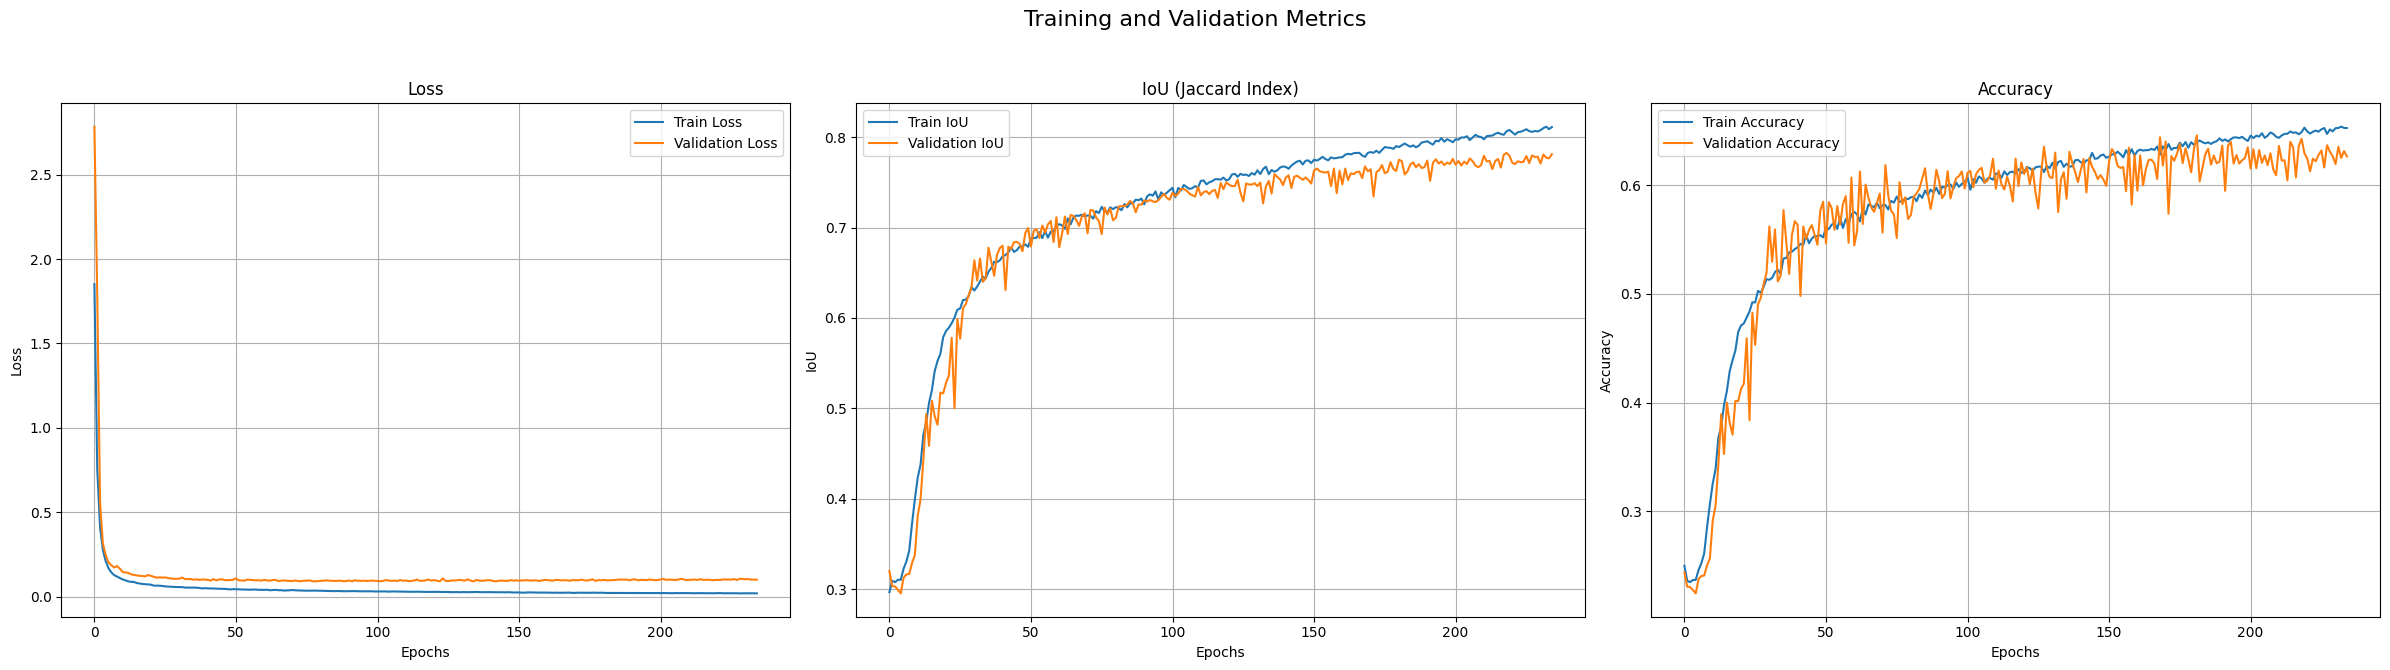

In [24]:
print("\nConverting training history to a DataFrame...")
history_df = pd.DataFrame(history)
history_df['epoch'] = range(1, len(history_df) + 1)
# Add accuracy to the DataFrame
history_df = history_df[['epoch', 'train_loss', 'train_iou', 'train_acc', 'val_loss', 'val_iou', 'val_acc']]
output_csv_path = 'training_results.csv'
history_df.to_csv(output_csv_path, index=False)
print(f"✅ Training results successfully saved to {output_csv_path}")
print(history_df.head())


# Plotting all metrics
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle("Training and Validation Metrics", fontsize=16)

# Loss Plot
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Validation Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# IoU Plot
axes[1].plot(history['train_iou'], label='Train IoU')
axes[1].plot(history['val_iou'], label='Validation IoU')
axes[1].set_title('IoU (Jaccard Index)')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('IoU')
axes[1].legend()
axes[1].grid(True)

# Accuracy Plot
axes[2].plot(history['train_acc'], label='Train Accuracy')
axes[2].plot(history['val_acc'], label='Validation Accuracy')
axes[2].set_title('Accuracy')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Accuracy')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()